In [ ]:
import os
import cv2 as cv
import numpy as np

# 定义网络模型和预训练模型路径
faceProto = "opencv_face_detector.pbtxt"
faceModel = "opencv_face_detector_uint8.pb"
ageProto = "age_deploy.prototxt"
ageModel = "age_net.caffemodel"
genderProto = "gender_deploy.prototxt"
genderModel = "gender_net.caffemodel"
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
#这些是github上找的预训练的模型和分类器
# 加载网络模型
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)
#定义获取人脸特征的函数
def get_face_box(net, frame, conf_threshold=0.5):
    frame_opencv_dnn = frame.copy()
    frame_height = frame_opencv_dnn.shape[0]
    frame_width = frame_opencv_dnn.shape[1]
    blob = cv.dnn.blobFromImage(frame_opencv_dnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frame_width)
            y1 = int(detections[0, 0, i, 4] * frame_height)
            x2 = int(detections[0, 0, i, 5] * frame_width)
            y2 = int(detections[0, 0, i, 6] * frame_height)
            # 扩大检测框
            x1 = max(0, x1 - 10)
            y1 = max(0, y1 - 10)
            x2 = min(frame_width, x2 + 10)
            y2 = min(frame_height, y2 + 10)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frame_opencv_dnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frame_height / 150)), 8)
    return frame_opencv_dnn, bboxes

# 处理并保存人脸图像
def process_and_save_faces(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(root, file)
                image = cv.imread(img_path)
                if image is None:
                    print(f"Warning: unable to read {img_path}")
                    continue
                frame, bboxes = get_face_box(faceNet, image)
                if not bboxes:
                    print(f"Warning: no faces detected in {img_path}")
                    continue
                for i, bbox in enumerate(bboxes):
                    face = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
                    if face.size == 0:
                        print(f"Warning: empty face image extracted from {img_path}")
                        continue
                    output_path = os.path.join(output_folder, f"{os.path.splitext(file)[0]}_face{i}.jpg")
                    cv.imwrite(output_path, face)
                    print(f"Saved face image to {output_path}")


input_folder = r'D:\machine learning\train'
output_folder = r'D:\machine learning\newtrain'
process_and_save_faces(input_folder, output_folder)


#重新将人脸特征的部分给筛选出来

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

# 定义标签列表
ageList = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-116']
genderList = [0, 1]
raceList = [0, 1, 2, 3, 4]

# 自定义数据集类
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []
        for img_name in os.listdir(root):
            img_path = os.path.join(root, img_name)
            if os.path.isfile(img_path):
                self.samples.append((img_path, img_name))
        
        # 打印找到的样本数
        print(f"Found {len(self.samples)} samples in {self.root}")

    def __len__(self):
        return len(self.samples)

    #获取标签函数，将图片的名称中的前三个标签提取出来
    def __getitem__(self, idx):
        img_path, img_name = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # 从文件名中提取标签
        labels = img_name.split('_')
        age = int(labels[0])
        gender_label = int(labels[1])  # 性别标签
        race_label = int(labels[2])  # 种族标签
        
        # 将年龄转换为对应的类别索引
        age_label = self.get_age_category(age)
        return image, torch.tensor([age_label, gender_label, race_label])

    #年龄标签需要特别处理，有些可能并不在自己定义的列表里
    def get_age_category(self, age):
        for i, age_range in enumerate(ageList):
            lower, upper = map(int, age_range.split('-'))
            if lower <= age <= upper:
                return i
        return len(ageList) - 1  # 如果年龄超过最大范围，返回最后一个类别

# 定义模型结构
# 原创，一切其他类似皆属于同学借鉴或其他行为
#这里借鉴tensorflow库里的caffe传统神经网络模型，设计的网络包含了5个卷积层（conv）和3个最大池化层（max pool）。每个卷积层后面都有一个ReLU激活函数。
#分类器部分包含两个全连接层（linear），每个全连接层之后有一个ReLU激活函数和一个Dropout层。
#output层包含三个独立的全连接层，分别对应年龄、性别和种族的分类任务。
class MyCaffeNet(nn.Module):
    def __init__(self, num_classes_age, num_classes_gender, num_classes_race):
        super(MyCaffeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True)
        )
        self.fc8_age = nn.Linear(4096, num_classes_age)
        self.fc8_gender = nn.Linear(4096, num_classes_gender)
        self.fc8_race = nn.Linear(4096, num_classes_race)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        age_outputs = self.fc8_age(x)
        gender_outputs = self.fc8_gender(x)
        race_outputs = self.fc8_race(x)
        return age_outputs, gender_outputs, race_outputs

# 实例化网络对象
#也可以直接传int值
num_classes_age = len(ageList)
num_classes_gender = len(genderList)
num_classes_race = len(raceList)
model = MyCaffeNet(num_classes_age, num_classes_gender, num_classes_race)

# 加载数据集
transform_train = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
])

# 检查并加载训练数据集
train_dataset = CustomDataset(root=r'D:\machine learning\newtrain', transform=transform_train)
print(f"Number of training samples: {len(train_dataset)}")

# 创建 DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义损失函数和优化器
criterion_age = nn.CrossEntropyLoss()
criterion_gender = nn.CrossEntropyLoss()
criterion_race = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        age_outputs, gender_outputs, race_outputs = model(inputs)
        age_loss = criterion_age(age_outputs, labels[:, 0])  
        gender_loss = criterion_gender(gender_outputs, labels[:, 1])  
        race_loss = criterion_race(race_outputs, labels[:, 2])
        loss = age_loss + gender_loss + race_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
# 保存模型
torch.save(model.state_dict(), 'my_caffenet_model.pth')
print("Model saved as my_caffenet_model.pth")

In [11]:
#定义绘制人脸特征的函数
import cv2 as cv
import time
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

# 检测人脸并绘制人脸bounding box，来自github
def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)
    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight / 150)), 8)
    return frameOpencvDnn, bboxes


In [12]:
# 加载 PyTorch 模型
ageList = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-116']
genderList = [0, 1]
raceList = [0, 1, 2, 3, 4]
num_classes_age = len(ageList)
num_classes_gender = len(genderList)
num_classes_race = len(raceList)
model = MyCaffeNet(num_classes_age, num_classes_gender, num_classes_race)
model.load_state_dict(torch.load('my_caffenet_model.pth'))#加载模型参数
model.eval()

# 定义图像预处理
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [14]:
image_folder = r'D:\machine learning\testset'
image_paths = [os.path.join(image_folder, img_name) for img_name in os.listdir(image_folder) if img_name.endswith('.jpg')]
padding = 20
# 在图像上绘制标签
text_size = 0.8  
text_thickness = 2  
text_color = (0, 255, 255)  
text_font = cv.FONT_HERSHEY_SIMPLEX

for image_file in image_paths:
    # 读取图像
    frame = cv.imread(image_file)
    cv.imshow("Image", frame)
    # 检测人脸并获取bounding box
    frameFace, bboxes = getFaceBox(faceNet, frame)
    # 如果没有检测到人脸，跳过当前图片
    if not bboxes:
        print("No face Detected in:", image_file)
        continue

    
    # 处理每个检测到的人脸
    for bbox in bboxes:
        # 截取人脸部分的图像
        face = frame[max(0, bbox[1] - 20):min(bbox[3] + 20, frame.shape[0] - 1),
                     max(0, bbox[0] - 20):min(bbox[2] + 20, frame.shape[1] - 1)]
        if face is None or face.size == 0:
            print("Empty face image detected, skipping...")
            continue
        # 转换为RGB格式的图像，并转换为PIL Image对象
        face = cv.cvtColor(face, cv.COLOR_BGR2RGB)
        face = Image.fromarray(face)
        # 对人脸图像进行预处理
        face_tensor = transform(face).unsqueeze(0)

        # 使用模型进行预测
        with torch.no_grad():
            age_outputs, gender_outputs, race_outputs = model(face_tensor)
            _, predicted_age = torch.max(age_outputs, 1)
            _, predicted_gender = torch.max(gender_outputs, 1)
            _, predicted_race = torch.max(race_outputs, 1)

        # 获取预测结果
        predicted_age = ageList[predicted_age.item()]
        predicted_gender = genderList[predicted_gender.item()]
        predicted_race = raceList[predicted_race.item()]
        # 构建标签
        label = "{}, {}, {}".format(predicted_gender, predicted_age, predicted_race)

        # 在图像上绘制标签
        cv.putText(frameFace, label, (bbox[0], bbox[1] - 20), text_font, text_size, text_color, text_thickness, cv.LINE_AA)

        # 显示带有标签的图像
        cv.imshow("Age Gender Race Demo", frameFace)

    # 等待按键
    cv.waitKey(0)  

    

Empty face image detected, skipping...
Empty face image detected, skipping...
No face Detected in: D:\machine learning\testset\019.jpg
Empty face image detected, skipping...
Empty face image detected, skipping...
Empty face image detected, skipping...
Empty face image detected, skipping...
No face Detected in: D:\machine learning\testset\040.jpg
Empty face image detected, skipping...
Empty face image detected, skipping...
Empty face image detected, skipping...
Empty face image detected, skipping...
Empty face image detected, skipping...
Empty face image detected, skipping...


KeyboardInterrupt: 

In [1]:
#验证阶段，定义标签对比

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
# 自定义数据集类
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []
        for class_name in os.listdir(root):
            class_dir = os.path.join(root, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if os.path.isfile(img_path):
                        self.samples.append((img_path, img_name))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, img_name = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # 从文件名中提取标签
        labels = img_name.split('_')
        age = int(labels[0])
        gender_label = int(labels[1])  # 性别标签
        race_label = int(labels[2])  # 种族标签
        
        # 将年龄转换为对应的类别索引
        age_label = self.get_age_category(age)
        
        return image, torch.tensor([age_label, gender_label, race_label])

    def get_age_category(self, age):#这个需要特殊定义，是个1-100数字
        for i, age_range in enumerate(ageList):
            lower, upper = map(int, age_range.split('-'))
            if lower <= age <= upper:
                return i
        return len(ageList) - 1  # 如果年龄超过最大范围，返回最后一个类别

In [22]:
#测试集计数
correct_age = 0
correct_gender = 0
correct_race = 0
total = 0
# 定义测试集的图像转换操作
transform_test = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 创建测试数据集和数据加载器
test_dataset = CustomDataset(root=r'D:\machine learning\test', transform=transform_test)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
model.eval()

# 禁用梯度计算
with torch.no_grad():
    for inputs, labels in test_dataloader:
        age_outputs, gender_outputs, race_outputs = model(inputs)
        _, predicted_age = torch.max(age_outputs, 1)
        _, predicted_gender = torch.max(gender_outputs, 1)
        _, predicted_race = torch.max(race_outputs, 1)
        total += labels.size(0)
        correct_age += (predicted_age == labels[:, 0]).sum().item()
        correct_gender += (predicted_gender == labels[:, 1]).sum().item()
        correct_race += (predicted_race == labels[:, 2]).sum().item()

# 计算准确率
accuracy_age = correct_age / total
accuracy_gender = correct_gender / total
accuracy_race = correct_race / total

# 打印准确率
print(f"Accuracy on test set (Age): {accuracy_age * 100:.2f}%")
print(f"Accuracy on test set (Gender): {accuracy_gender * 100:.2f}%")
print(f"Accuracy on test set (Race): {accuracy_race * 100:.2f}%")



#没有预测集的时候的自己找了些图片预测的结果

Accuracy on test set (Age): 68.52%
Accuracy on test set (Gender): 94.44%
Accuracy on test set (Race): 50.00%


In [9]:
#测试集的预测过程

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# 定义年龄、性别和种族列表
ageList = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-116']
genderList = ['Male', 'Female']  # 使用更直观的标签
raceList = ['Race0', 'Race1', 'Race2', 'Race3', 'Race4']

# 自定义数据集类
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = [os.path.join(root, img_name) for img_name in os.listdir(root) if os.path.isfile(os.path.join(root, img_name))]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        img_name = os.path.basename(img_path)
        return image, img_name

# 定义测试集的图像转换操作
transform_test = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 创建测试数据集和数据加载器
test_dataset = CustomDataset(root=r'D:\machine learning\testset', transform=transform_test)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 定义模型类
class MyCaffeNet(nn.Module):
    def __init__(self, num_classes_age, num_classes_gender, num_classes_race):
        super(MyCaffeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True)
        )
        self.fc8_age = nn.Linear(4096, num_classes_age)
        self.fc8_gender = nn.Linear(4096, num_classes_gender)
        self.fc8_race = nn.Linear(4096, num_classes_race)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        age_outputs = self.fc8_age(x)
        gender_outputs = self.fc8_gender(x)
        race_outputs = self.fc8_race(x)
        return age_outputs, gender_outputs, race_outputs

# 加载模型
num_classes_age = len(ageList)
num_classes_gender = len(genderList)
num_classes_race = len(raceList)
model = MyCaffeNet(num_classes_age, num_classes_gender, num_classes_race)
model.load_state_dict(torch.load('my_caffenet_model.pth'))
model.eval()

# 输出文件路径
output_file = 'newpredictions.txt'

# 打开文件以写入
with open(output_file, 'w') as f:
    # 处理每张图像并进行预测
    for inputs, img_name in test_dataloader:
        inputs = inputs.to('cpu')  # 如果使用GPU训练模型，请确保将输入转移到正确的设备上
        age_outputs, gender_outputs, race_outputs = model(inputs)
        _, predicted_age = torch.max(age_outputs, 1)
        _, predicted_gender = torch.max(gender_outputs, 1)
        _, predicted_race = torch.max(race_outputs, 1)
        
        # 获取对应的标签
        age_label = ageList[predicted_age.item()]
        gender_label = genderList[predicted_gender.item()]
        race_label = raceList[predicted_race.item()]
        
        # 打印并保存预测结果
        predicted_label = f"{img_name[0].split('.')[0]}-{gender_label}-{age_label}-{race_label}"
        print(predicted_label)
        f.write(predicted_label + '\n')


001-Male-0-10-Race0
002-Female-11-20-Race0
003-Male-0-10-Race0
004-Female-21-30-Race0
005-Female-11-20-Race0
006-Female-0-10-Race0
007-Female-21-30-Race3
008-Male-0-10-Race0
009-Male-21-30-Race3
010-Male-21-30-Race0
011-Male-61-70-Race0
012-Female-21-30-Race0
013-Male-0-10-Race0
014-Male-0-10-Race0
015-Male-0-10-Race0
016-Male-11-20-Race0
017-Female-11-20-Race0
018-Male-11-20-Race0
019-Female-0-10-Race0
020-Male-0-10-Race0
021-Female-0-10-Race0
022-Male-0-10-Race2
023-Female-21-30-Race0
024-Male-21-30-Race0
025-Male-0-10-Race0
026-Male-0-10-Race0
027-Male-31-40-Race3
028-Male-0-10-Race0
029-Female-0-10-Race0
030-Male-0-10-Race0
031-Female-21-30-Race0
032-Female-21-30-Race0
033-Male-0-10-Race0
034-Male-0-10-Race2
035-Male-0-10-Race0
036-Male-0-10-Race0
037-Male-0-10-Race0
038-Male-11-20-Race0
039-Male-0-10-Race2
040-Female-11-20-Race0
041-Male-0-10-Race0
042-Female-0-10-Race0
043-Female-21-30-Race0
044-Male-11-20-Race0
045-Female-0-10-Race0
046-Male-61-70-Race0
047-Female-21-30-Race0
04

Duplicate key in file WindowsPath('D:/anaconda/conda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 789 ('font.family         : sans-serif')
Duplicate key in file WindowsPath('D:/anaconda/conda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 790 ('font.sans-serif         : SimHei')
Duplicate key in file WindowsPath('D:/anaconda/conda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 791 ('axes.unicode_minus  : False')


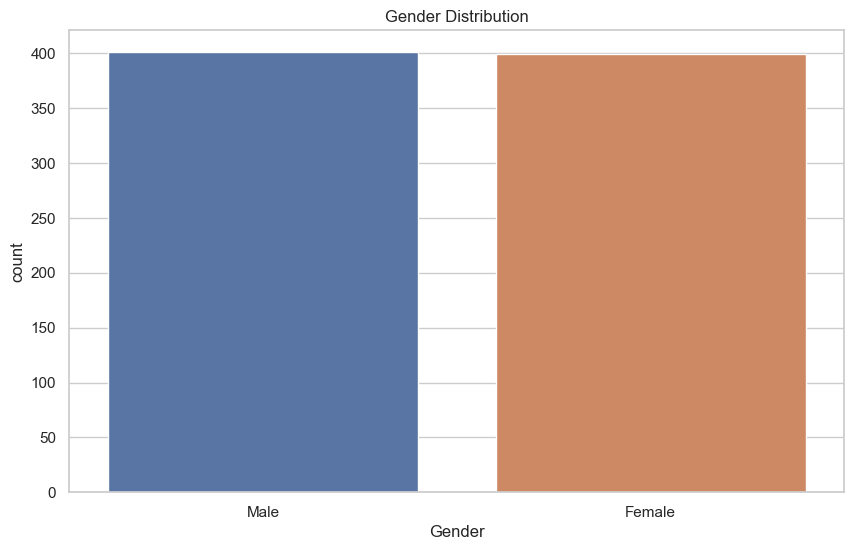

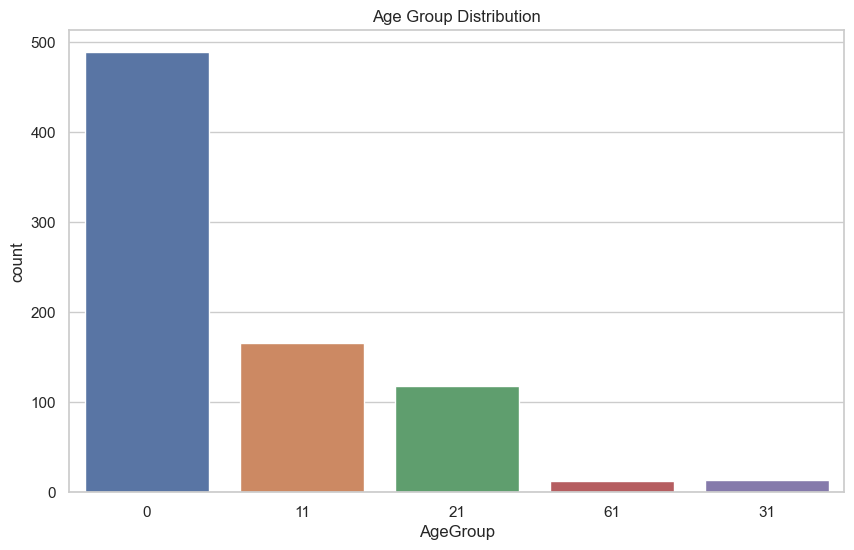

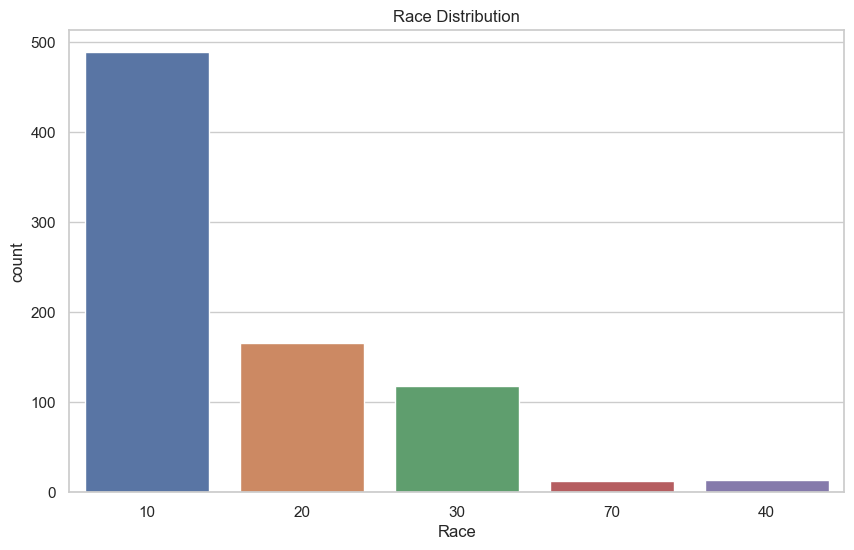

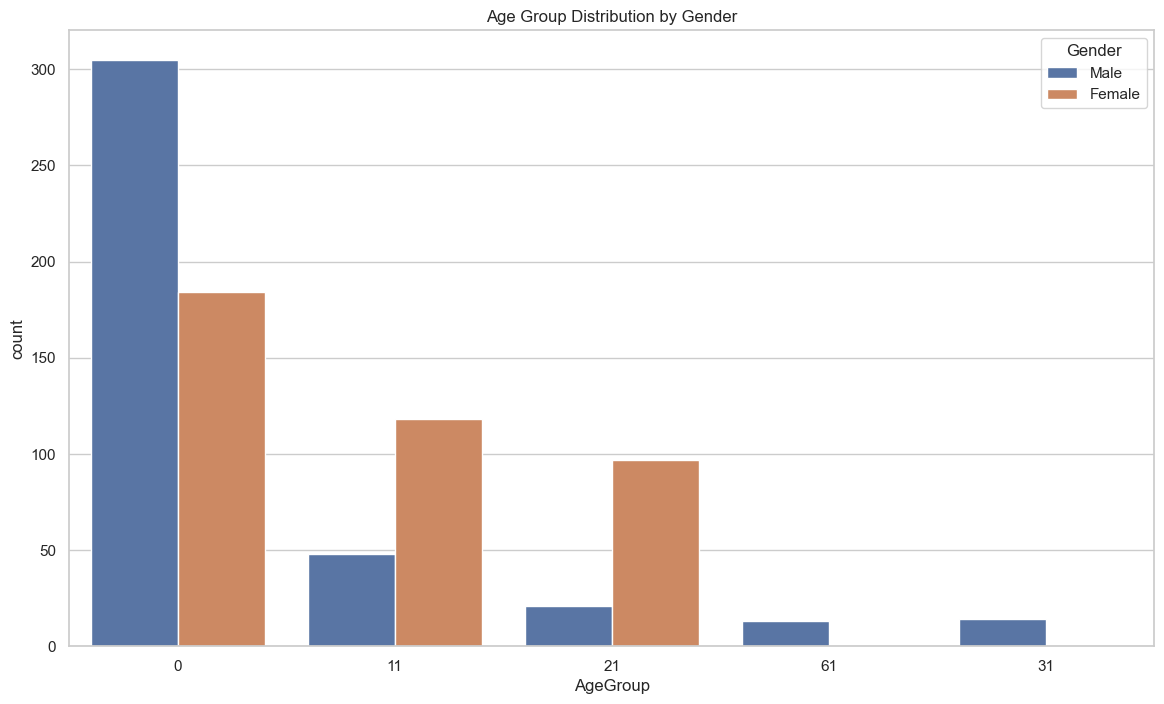

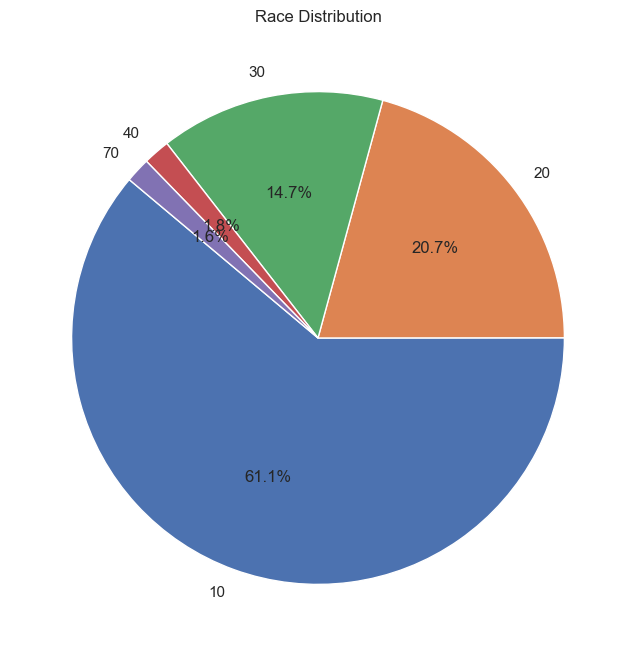

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 定义读取文件的函数
def read_txt(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

# 读取数据
file_path = 'newpredictions.txt'
data = read_txt(file_path)

# 解析数据
parsed_data = []
for entry in data:
    parts = entry.split('-')
    parsed_data.append({
        'ID': parts[0],
        'Gender': parts[1],
        'AgeGroup': parts[2],
        'Race': parts[3]
    })

# 转换为DataFrame
df = pd.DataFrame(parsed_data)

# 设置绘图风格
sns.set(style="whitegrid")

# 绘制性别分布条形图
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Gender')
plt.title('Gender Distribution')
plt.show()

# 绘制年龄组分布条形图
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='AgeGroup')
plt.title('Age Group Distribution')
plt.show()

# 绘制种族分布条形图
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Race')
plt.title('Race Distribution')
plt.show()

# 绘制性别和年龄组的组合分布条形图
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='AgeGroup', hue='Gender')
plt.title('Age Group Distribution by Gender')
plt.show()

# 绘制种族分布饼图
race_counts = df['Race'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Race Distribution')
plt.show()


In [6]:
#计数
from collections import Counter

def check_data_distribution(root):
    age_counter = Counter()
    gender_counter = Counter()
    race_counter = Counter()
    for img_name in os.listdir(root):
        if not img_name.endswith(('.png', '.jpg', '.jpeg')):
            continue
        labels = img_name.split('_')
        age_counter[labels[0]] += 1
        gender_counter[labels[1]] += 1
        race_counter[labels[2]] += 1
    
    print("Age distribution:", age_counter)
    print("Gender distribution:", gender_counter)
    print("Race distribution:", race_counter)

check_data_distribution(r'D:\machine learning\newtrain')


Age distribution: Counter({'1': 1493, '2': 608, '3': 329, '26': 311, '4': 285, '8': 252, '16': 243, '24': 228, '5': 188, '25': 187, '18': 184, '22': 181, '28': 178, '29': 175, '32': 175, '60': 173, '39': 171, '9': 168, '21': 165, '52': 165, '15': 164, '14': 162, '56': 155, '35': 150, '53': 149, '36': 148, '10': 146, '27': 143, '7': 141, '85': 133, '30': 130, '54': 128, '12': 126, '20': 126, '49': 124, '58': 119, '6': 119, '65': 118, '31': 117, '17': 116, '50': 116, '37': 113, '23': 112, '40': 111, '34': 107, '42': 104, '38': 101, '75': 101, '45': 99, '47': 95, '13': 92, '62': 83, '72': 83, '48': 80, '90': 79, '19': 77, '46': 74, '51': 73, '80': 72, '11': 68, '41': 68, '68': 65, '43': 64, '59': 64, '70': 64, '55': 63, '57': 60, '63': 59, '69': 59, '61': 58, '66': 57, '67': 54, '33': 52, '76': 38, '44': 37, '78': 37, '82': 36, '73': 33, '64': 31, '71': 26, '77': 23, '79': 21, '86': 18, '88': 17, '74': 16, '89': 16, '92': 14, '96': 14, '81': 11, '84': 9, '110': 5, '83': 5, '93': 5, '99': 